In [ ]:
# Import Libraries
! pip install git+https://github.com/JBjoernskov/Twin4Build.git@feature/issue-74/batched-component-execution

import twin4build as tb
import torch
import numpy as np
import pandas as pd
import datetime
import time
from dateutil import tz
import tempfile
import os
import torch.nn as nn
import twin4build.utils.types as tps
import twin4build.examples.utils as utils

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


# Building Energy Management: Parameter Estimation and Optimal Control

## System Description

This lecture demonstrates a complete building energy management workflow using a **two-room building model**. We'll learn how to:

1. **Model** the thermal dynamics using RC networks and state-space equations
2. **Estimate** thermal parameters from measurement data  
3. **Validate** the calibrated model against real measurements
4. **Optimize** heating control for energy savings

### Physical System

Our building consists of two rooms connected by an interior wall:

- **States**: `x = [T_a, T_wa, T_i, T_b, T_wb]` (room and wall temperatures)
- **Inputs**: `u = [Q_h, Q_r, T_out]` (heating power, solar gains, outdoor temperature)
- **Outputs**: `y = [T_a, T_wa, T_i, T_b, T_wb]` (all temperatures are measured)

The system follows **state-space form**:
```
dx/dt = A*x + B*u
y = C*x + D*u
```



Where:
- **A matrix** (5×5): Internal thermal coupling between states
- **B matrix** (5×3): How inputs affect each state  
- **C matrix** (5×5): Output mapping (identity since we measure all states)
- **D matrix** (5×3): Direct input-to-output coupling (typically zero)

![System Diagram](bems_exercise.png)

*The RC network represents thermal resistances (R) and capacitances (C) between room air, walls, and outdoor environment. The top diagram shows the physical building layout, while the bottom shows the equivalent electrical circuit used for modeling.*


In [2]:
# 🎯 **YOUR TASK: Complete this function**

def build_state_space_matrices(R_wa, R_ia, R_wao, R_ib, R_wb, R_wbo,
                                C_a, C_wa, C_i, C_b, C_wb):
    """
    STUDENT EXERCISE: Complete the A, B, C, D matrices based on the RC network
    
    Given parameters:
    - Thermal resistances: R_wa, R_ia, R_wao, R_ib, R_wb, R_wbo [K/W]
    - Thermal capacitances: C_a, C_wa, C_i, C_b, C_wb [J/K]
    
    State vector: x = [T_a, T_wa, T_i, T_b, T_wb]
    Input vector: u = [Q_h, Q_r, T_out]
    Output vector: y = [T_a, T_wa, T_i, T_b, T_wb]
    
    Hint: From the RC network equations:
    - dT_a/dt = (T_wa - T_a)/(R_wa*C_a) + (T_i - T_a)/(R_ia*C_a) + Q_h/C_a
    - dT_wa/dt = (T_a - T_wa)/(R_wa*C_wa) + (T_out - T_wa)/(R_wao*C_wa)
    - ... (continue for T_i, T_b, T_wb)
    """

    # Initialize matrices
    A = torch.zeros((5, 5), dtype=torch.float64)
    B = torch.zeros((5, 3), dtype=torch.float64)
    C = torch.zeros((5, 5), dtype=torch.float64)
    D = torch.zeros((5, 3), dtype=torch.float64)

    # Solution
    A[0, 0] = -(1/(R_wa * C_a) + 1/(R_ia * C_a))
    A[0, 1] = 1/(R_wa * C_a)
    A[0, 2] = 1/(R_ia * C_a)
    A[1, 0] = 1/(R_wa * C_wa)
    A[1, 1] = -(1/(R_wa * C_wa) + 
                1/(R_wao * C_wa))
    A[2, 0] = 1/(R_ia * C_i)
    A[2, 2] = -(1/(R_ia * C_i) + 
                1/(R_ib * C_i))
    A[2, 3] = 1/(R_ib * C_i)
    A[3, 2] = 1/(R_ib * C_b)
    A[3, 3] = -(1/(R_wb * C_b) + 
                1/(R_ib * C_b))
    A[3, 4] = 1/(R_wb * C_b)
    A[4, 3] = 1/(R_wb * C_wb)
    A[4, 4] = -(1/(R_wb * C_wb) + 
                1/(R_wbo * C_wb))
    
    B[0, 0] = 1/C_a
    B[3, 1] = 1/C_b
    B[1, 2] = 1/(R_wao * C_wa)
    B[4, 2] = 1/(R_wbo * C_wb)

    C = torch.eye(5, dtype=torch.float64)


    # ========================================================================
    # TODO: Fill in the A matrix (5x5) - Internal thermal coupling
    # ========================================================================
    # Row 0: dT_a/dt equation
    # A[0, 0] = ???  # Effect of T_a on itself
    # A[0, 1] = ???  # Effect of T_wa on T_a
    # A[0, 2] = ???  # Effect of T_i on T_a
    
    # Row 1: dT_wa/dt equation
    # A[1, 0] = ???  # Effect of T_a on T_wa
    # A[1, 1] = ???  # Effect of T_wa on itself
    
    # Row 2: dT_i/dt equation
    # A[2, 0] = ???  # Effect of T_a on T_i
    # A[2, 2] = ???  # Effect of T_i on itself
    # A[2, 3] = ???  # Effect of T_b on T_i
    
    # Row 3: dT_b/dt equation
    # A[3, 2] = ???  # Effect of T_i on T_b
    # A[3, 3] = ???  # Effect of T_b on itself
    # A[3, 4] = ???  # Effect of T_wb on T_b
    
    # Row 4: dT_wb/dt equation
    # A[4, 3] = ???  # Effect of T_b on T_wb
    # A[4, 4] = ???  # Effect of T_wb on itself
    
    # TODO: Fill in your A matrix based on the RC network equations
    # Example for A[0,0]: A[0, 0] = -(1/(R_wa * C_a) + 1/(R_ia * C_a))
    
    
    # ========================================================================
    # TODO: Fill in the B matrix (5x3) - Input effects
    # ========================================================================
    # Columns: [Q_h, Q_r, T_out]
    
    # B[0, 0] = ???  # Effect of Q_h on T_a
    # B[1, 2] = ???  # Effect of T_out on T_wa
    # B[3, 1] = ???  # Effect of Q_r on T_b
    # B[4, 2] = ???  # Effect of T_out on T_wb
    
    # TODO: Fill in your B matrix
    # Which inputs affect which states?
    
    
    # ========================================================================
    # TODO: Fill in the C matrix (5x5) - Output mapping
    # ========================================================================
    # We observe all states directly, so C should be...?
    
    # TODO: What is C if we observe all states directly?
    
    
    # ========================================================================
    # TODO: Fill in the D matrix (5x3) - Direct feedthrough
    # ========================================================================
    # Is there any direct input-to-output path (bypassing states)?
    
    # TODO: Is there direct input-to-output coupling (no states involved)?
    
    
    return A, B, C, D


In [3]:
# Helper Functions and Classes (you can ignore this)

class ThermalParameters:
    """Container for building thermal parameters"""
    
    def __init__(self, R_wa=0.014, R_ia=0.005, R_wao=0.016,
                 R_ib=0.004, R_wb=0.014, R_wbo=0.018,
                 C_a=5e5, C_wa=15e5, C_i=1e5, C_b=1e5, C_wb=3e5):
        # Thermal resistances [K/W]
        self.R_wa = R_wa      # Room A air to wall
        self.R_ia = R_ia      # Room A air to interior wall
        self.R_wao = R_wao    # Room A wall to outdoor
        self.R_ib = R_ib      # Interior wall to Room B air
        self.R_wb = R_wb      # Room B air to wall
        self.R_wbo = R_wbo    # Room B wall to outdoor
        
        # Thermal capacitances [J/K]
        self.C_a = C_a        # Room A air
        self.C_wa = C_wa      # Room A wall
        self.C_i = C_i        # Interior wall
        self.C_b = C_b        # Room B air
        self.C_wb = C_wb      # Room B wall


def _build_model(df, params):
    """Build Twin4Build model using the state-space matrices"""
    
    # Create parametric system class
    class ParametricSystem(tb.core.System, nn.Module):
        def __init__(self, params, **kwargs):
            super().__init__(**kwargs)
            nn.Module.__init__(self)
            
            # Store parameters as learnable tensors
            self.R_wa_param = tps.Parameter(torch.tensor(params.R_wa, dtype=torch.float64))
            self.R_ia_param = tps.Parameter(torch.tensor(params.R_ia, dtype=torch.float64))
            self.R_wao_param = tps.Parameter(torch.tensor(params.R_wao, dtype=torch.float64))
            self.R_ib_param = tps.Parameter(torch.tensor(params.R_ib, dtype=torch.float64))
            self.R_wb_param = tps.Parameter(torch.tensor(params.R_wb, dtype=torch.float64))
            self.R_wbo_param = tps.Parameter(torch.tensor(params.R_wbo, dtype=torch.float64))
            self.C_a_param = tps.Parameter(torch.tensor(params.C_a, dtype=torch.float64))
            self.C_wa_param = tps.Parameter(torch.tensor(params.C_wa, dtype=torch.float64))
            self.C_i_param = tps.Parameter(torch.tensor(params.C_i, dtype=torch.float64))
            self.C_b_param = tps.Parameter(torch.tensor(params.C_b, dtype=torch.float64))
            self.C_wb_param = tps.Parameter(torch.tensor(params.C_wb, dtype=torch.float64))
            
            self.input = {"u": tps.Vector(size=3)}
            self.output = {"y": tps.Vector(size=5)}
            
            self.parameter = {
                "R_wa_param": {"lb": 0.001, "ub": 0.1},
                "R_ia_param": {"lb": 0.001, "ub": 0.1},
                "R_wao_param": {"lb": 0.001, "ub": 0.1},
                "R_ib_param": {"lb": 0.001, "ub": 0.1},
                "R_wb_param": {"lb": 0.001, "ub": 0.1},
                "R_wbo_param": {"lb": 0.001, "ub": 0.1},
                "C_a_param": {"lb": 1e5, "ub": 5e6},
                "C_wa_param": {"lb": 1e5, "ub": 2e6},
                "C_i_param": {"lb": 1e5, "ub": 5e6},
                "C_b_param": {"lb": 1e5, "ub": 5e6},
                "C_wb_param": {"lb": 1e5, "ub": 2e6},
            }
            
            self._config = {"parameters": list(self.parameter.keys())}
            self.INITIALIZED = False
            self._create_ss()
        
        def _create_ss(self):
            """Create state-space model using the matrices"""
            A, B, C, D = build_state_space_matrices(
                self.R_wa_param.get(), self.R_ia_param.get(), self.R_wao_param.get(),
                self.R_ib_param.get(), self.R_wb_param.get(), self.R_wbo_param.get(),
                self.C_a_param.get(), self.C_wa_param.get(), self.C_i_param.get(),
                self.C_b_param.get(), self.C_wb_param.get()
            )
            
            x0 = torch.tensor([18.0, 12.0, 15.0, 16.0, 11.0], dtype=torch.float64)
            
            self.ss_model = tb.DiscreteStatespaceSystem(
                A=A, B=B, C=C, D=D, x0=x0,
                state_names=["T_a", "T_wa", "T_i", "T_b", "T_wb"],
                sample_time=600.0,
                id=f"ss_model_{self.id}"
            )
        
        @property
        def config(self):
            return self._config
        
        def initialize(self, start_time, end_time, step_size):
            _, _, n_timesteps = tb.Simulator.get_simulation_timesteps(start_time, end_time, step_size)
            batch_size = len(start_time)
            for port in self.input.values():
                port.initialize(n_timesteps, batch_size=batch_size)
            for port in self.output.values():
                port.initialize(n_timesteps, batch_size=batch_size)
            
            self._create_ss()
            self.ss_model.initialize(start_time, end_time, step_size)
            self.INITIALIZED = True
        
        def do_step(self, second_time=None, date_time=None, step_size=None, step_index=None):
            self.ss_model.input["u"].set(self.input["u"].get(), step_index=step_index)
            self.ss_model.do_step(second_time, date_time, step_size, step_index=step_index)
            self.output["y"].set(self.ss_model.output["y"].get(), step_index)
    
    # Build model
    with tempfile.TemporaryDirectory() as temp_dir:
        # Save measurements
        temp_a_file = os.path.join(temp_dir, "T_a.csv")
        temp_b_file = os.path.join(temp_dir, "T_b.csv")
        pd.DataFrame({'measuredValue': df['T_a_measured']}, index=df.index).to_csv(temp_a_file)
        pd.DataFrame({'measuredValue': df['T_b_measured']}, index=df.index).to_csv(temp_b_file)
        
        # Create model
        model = tb.Model(id="building_model")
        
        thermal_sys = ParametricSystem(params, sample_time=600.0, id="ThermalSystem")
        radiator = tb.TimeSeriesInputSystem(
            df=pd.DataFrame({'radiatorHeat': df['Q_h']}, index=df.index), id="RadiatorInput")
        window = tb.TimeSeriesInputSystem(
            df=pd.DataFrame({'windowHeat': df['Q_r']}, index=df.index), id="WindowInput")
        outdoor = tb.TimeSeriesInputSystem(
            df=pd.DataFrame({'outdoorTemperature': df['T_out']}, index=df.index), id="OutdoorInput")
        temp_a_sensor = tb.SensorSystem(
            df=pd.read_csv(temp_a_file, index_col=0, parse_dates=True), id="TempASensor")
        temp_b_sensor = tb.SensorSystem(
            df=pd.read_csv(temp_b_file, index_col=0, parse_dates=True), id="TempBSensor")
        
        # Connect
        model.add_connection(radiator, thermal_sys, "value", "u", input_port_index=0)
        model.add_connection(window, thermal_sys, "value", "u", input_port_index=1)
        model.add_connection(outdoor, thermal_sys, "value", "u", input_port_index=2)
        model.add_connection(thermal_sys, temp_a_sensor, "y", "measuredValue", output_port_index=0)
        model.add_connection(thermal_sys, temp_b_sensor, "y", "measuredValue", output_port_index=3)
        
        model.load(verbose=0)
        return model

print("✓ Helper functions loaded successfully")


✓ Helper functions loaded successfully


In [4]:
# Verification: Check your matrices before proceeding
def verify_matrices():
    """Verify that your matrices have the correct structure and content"""
    print("="*60)
    print("VERIFYING YOUR STATE-SPACE MATRICES")
    print("="*60)

    # Test parameters
    test_params = ThermalParameters(
        R_wa=0.01, R_ia=0.002, R_wao=0.01,
        R_ib=0.002, R_wb=0.01, R_wbo=0.01,
        C_a=1e6, C_wa=5e5, C_i=1e6, C_b=1e6, C_wb=5e5
    )
    
    A, B, C, D = build_state_space_matrices(
        test_params.R_wa, test_params.R_ia, test_params.R_wao,
        test_params.R_ib, test_params.R_wb, test_params.R_wbo,
        test_params.C_a, test_params.C_wa, test_params.C_i,
        test_params.C_b, test_params.C_wb
    )
    
    # Check dimensions and content
    checks_passed = 0
    total_checks = 9
    
    print("\n📐 Dimension checks:")
    if A.shape == (5, 5):
        print("✓ A matrix is 5x5")
        checks_passed += 1
    else:
        print("✗ A matrix should be 5x5, got", A.shape)
    
    if B.shape == (5, 3):
        print("✓ B matrix is 5x3")
        checks_passed += 1
    else:
        print("✗ B matrix should be 5x3, got", B.shape)
    
    if C.shape == (5, 5):
        print("✓ C matrix is 5x5")
        checks_passed += 1
    else:
        print("✗ C matrix should be 5x5, got", C.shape)
    
    if D.shape == (5, 3):
        print("✓ D matrix is 5x3")
        checks_passed += 1
    else:
        print("✗ D matrix should be 5x3, got", D.shape)
    
    # Check if matrices have been filled in (not all zeros)
    print("\n🔍 Content checks:")
    if torch.any(A != 0):
        print("✓ A matrix has been filled in")
        checks_passed += 1
    else:
        print("✗ A matrix appears empty - please fill it in")
    
    if torch.any(B != 0):
        print("✓ B matrix has been filled in")
        checks_passed += 1
    else:
        print("✗ B matrix appears empty - please fill it in")

    if torch.any(C != 0):
        print("✓ C matrix has been filled in")
        checks_passed += 1
    else:
        print("✗ C matrix appears empty - please fill it in")


    data_file = utils.get_path(["bems_lecture", "bems_example_reference.csv"])
    df_ref = pd.read_csv(data_file, index_col=0, parse_dates=True)

    data_file = utils.get_path(["bems_lecture", "building_measurements.csv"])
    df = pd.read_csv(data_file, index_col=0, parse_dates=True)

    model = _build_model(df, test_params)

    # Create estimator
    simulator = tb.Simulator(model)

    # Run initial simulation
    simulator.simulate(
        step_size=600,
        start_time=df.index[0],
        end_time=df.index[-1] + pd.Timedelta(seconds=600)
    )

    print(df_ref.columns)

    if torch.allclose(model.components["ThermalSystem"].output["y"].history[0,:,0], torch.tensor(df_ref['reference_T_a'].values)):
        print("✓ Initial simulation passed")
        checks_passed += 1
    else:
        print("✗ Initial simulation failed")


    if torch.allclose(model.components["ThermalSystem"].output["y"].history[0,:,3], torch.tensor(df_ref['reference_T_b'].values)):
        print("✓ Initial simulation passed")
        checks_passed += 1
    else:
        print("✗ Initial simulation failed")


    
    print(f"\n📊 Results: {checks_passed}/{total_checks} checks passed")
    
    if checks_passed == total_checks:
        print("\n🎉 Excellent! Your matrices look good.")
        print("✓ Ready to proceed with parameter estimation")
        return True
    else:
        print("\n⚠️  Please complete the matrices before proceeding.")
        print("💡 Hint: Look at the RC network diagram and differential equations")
        return False

# Run verification (comment out this line if matrices aren't ready yet)
validated = verify_matrices()

if validated==False:
    raise ValueError("Your matrices does not look correct, please check the RC network diagram and differential equations")


VERIFYING YOUR STATE-SPACE MATRICES

📐 Dimension checks:
✓ A matrix is 5x5
✓ B matrix is 5x3
✓ C matrix is 5x5
✓ D matrix is 5x3

🔍 Content checks:
✓ A matrix has been filled in
✓ B matrix has been filled in
✓ C matrix has been filled in


C:\Users\jabj\Documents\python\Twin4Build\twin4build\systems\utils\time_series_input_system.py:94: MainPathNotFound: Could not determine main module path, using temp dir: C:\Users\jabj\AppData\Local\Temp\1
  self._cache_root = get_main_dir()
100%|██████████| 432/432 [00:00<00:00, 3138.23it/s]

Index(['time', 'reference_T_a', 'reference_T_b'], dtype='object')
✓ Initial simulation passed
✓ Initial simulation passed

📊 Results: 9/9 checks passed

🎉 Excellent! Your matrices look good.
✓ Ready to proceed with parameter estimation


## Step 1: Load Measurement Data

In this step, we load real building measurement data that will be used to:
- **Calibrate** our thermal model parameters
- **Validate** the model accuracy
- **Optimize** the heating control strategy

The dataset contains:
- **Room temperatures**: `T_a_measured`, `T_b_measured` (°C)
- **Heating power**: `Q_h` (W) - radiator heat input to room A
- **Solar gains**: `Q_r` (W) - solar heat gains through windows in room B  
- **Outdoor temperature**: `T_out` (°C) - external weather conditions

**Key insight**: Real building data contains noise, disturbances, and complex dynamics that make parameter estimation challenging but realistic.


STEP 1: LOADING MEASUREMENT DATA
✓ Loaded 432 measurements
✓ Period: 2024-01-01 00:00:00+01:00 to 2024-01-03 23:50:00+01:00
✓ Columns: ['T_a_measured', 'T_b_measured', 'Q_h', 'Q_r', 'T_out']

📊 Data summary:
   Duration: 3 days
   Sampling: 10 minutes
   Temperature range: 9.1 - 28.6 °C


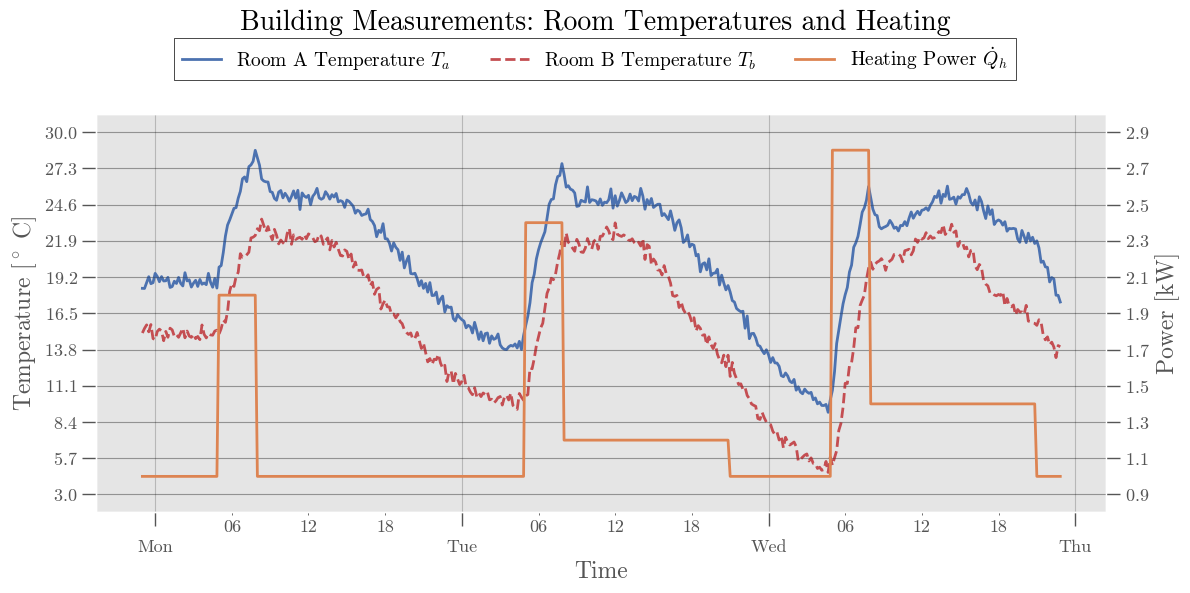

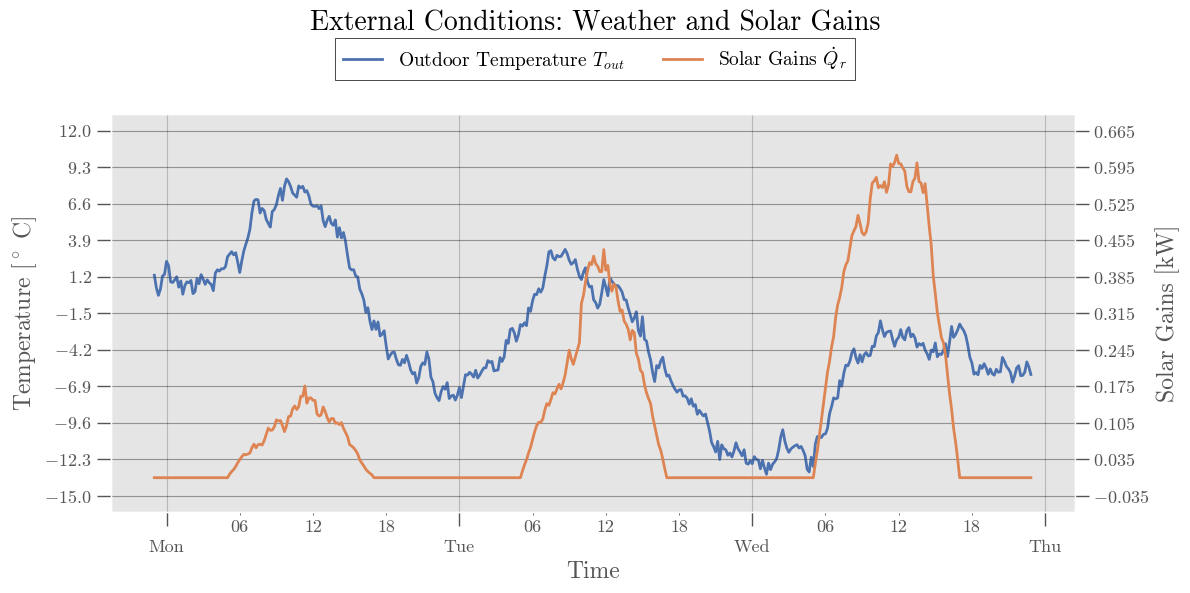

In [5]:
# Load and visualize measurement data
def load_data():
    """Load building measurement data"""
    print("="*60)
    print("STEP 1: LOADING MEASUREMENT DATA")
    print("="*60)
    
    # Load measurement data
    data_file = utils.get_path(["bems_lecture", "building_measurements.csv"])
    df = pd.read_csv(data_file, index_col=0, parse_dates=True)
    
    print(f"✓ Loaded {len(df)} measurements")
    print(f"✓ Period: {df.index[0]} to {df.index[-1]}")
    print(f"✓ Columns: {list(df.columns)}")
    
    # Plot room temperatures and heating
    fig, axes = tb.plot.plot(
        time=df.index,
        entries=[
            tb.plot.Entry(data=df['T_a_measured'].values, 
                         label=r"Room A Temperature $T_a$", color=tb.plot.Colors.blue, fmt="-", axis=1),
            tb.plot.Entry(data=df['T_b_measured'].values, 
                         label=r"Room B Temperature $T_b$", color=tb.plot.Colors.red, fmt="--", axis=1),
            tb.plot.Entry(data=df['Q_h'].values/1000, 
                         label=r"Heating Power $\dot{Q}_h$", color=tb.plot.Colors.orange, fmt="-", axis=2),
        ],
        ylabel_1axis=r"Temperature $[^\circ$ C$]$",
        ylabel_2axis="Power [kW]",
        title="Building Measurements: Room Temperatures and Heating",
        show=False,
        nticks=11
    )
    # fig.savefig("bems_room_measurements.png", dpi=300)
    
    # Plot outdoor conditions
    fig, axes = tb.plot.plot(
        time=df.index,
        entries=[
            tb.plot.Entry(data=df['T_out'].values, 
                         label=r"Outdoor Temperature $T_{out}$", color=tb.plot.Colors.blue, fmt="-", axis=1),
            tb.plot.Entry(data=df['Q_r'].values/1000, 
                         label=r"Solar Gains $\dot{Q}_r$", color=tb.plot.Colors.orange, fmt="-", axis=2),
        ],
        ylabel_1axis=r"Temperature $[^\circ$ C$]$",
        ylabel_2axis="Solar Gains [kW]",
        title="External Conditions: Weather and Solar Gains",
        show=False,
        align_zero=False,
        nticks=11
    )
    # fig.savefig("bems_outdoor_measurements.png", dpi=300)
    
    return df

# Execute data loading
df = load_data()
print(f"\n📊 Data summary:")
print(f"   Duration: {(df.index[-1] - df.index[0]).total_seconds()/3600/24:.0f} days")
print(f"   Sampling: {(df.index[1] - df.index[0]).total_seconds()/60:.0f} minutes")
print(f"   Temperature range: {df['T_a_measured'].min():.1f} - {df['T_a_measured'].max():.1f} °C")


## Step 2: Parameter Estimation
### 👥 **Follow-Along Demonstration**

**Objective**: Estimate the 11 thermal parameters (6 resistances + 5 capacitances) from measurement data.

**The Challenge**: We have a **nonlinear optimization problem**:
- **11 unknown parameters** to estimate
- **Thousands of measurements** to fit
- **Complex thermal dynamics** with time delays and coupling

**Method**: We use **automatic differentiation** with gradient-based optimization:
1. Start with an **initial guess** (deliberately poor)
2. **Simulate** the model with current parameters  
3. **Compare** simulation vs. measurements (minimize MSE)
4. **Update** parameters using gradients
5. **Repeat** until convergence

**Key insight**: Good parameter estimation requires **rich excitation** - the heating and weather inputs must vary enough to reveal the thermal characteristics.


STEP 2: PARAMETER ESTIMATION


100%|██████████| 432/432 [00:00<00:00, 2679.59it/s]



📊 Before calibration:
   RMSE Room A: 8.597 °C
   RMSE Room B: 6.700 °C

🔧 Running parameter estimation...
   Method: Gradient-based optimization (SLSQP)
   Parameters: 11
   Measurements: 2 sensors
✅ Estimation completed in 55.5 seconds

PARAMETER ESTIMATION RESULTS
Parameter    Unit     Initial        Estimated     
------------------------------------------------------------
R_wa         K/W      1.000e-02      1.395e-02     
R_ia         K/W      2.000e-03      1.000e-03     
R_wao        K/W      1.000e-02      1.759e-02     
R_ib         K/W      2.000e-03      7.416e-03     
R_wb         K/W      1.000e-02      1.783e-02     
R_wbo        K/W      1.000e-02      1.226e-02     
C_a          J/K      1.000e+06      4.212e+05     
C_wa         J/K      5.000e+05      1.450e+06     
C_i          J/K      1.000e+06      1.446e+05     
C_b          J/K      1.000e+06      1.624e+05     
C_wb         J/K      5.000e+05      3.525e+05     
----------------------------------------------

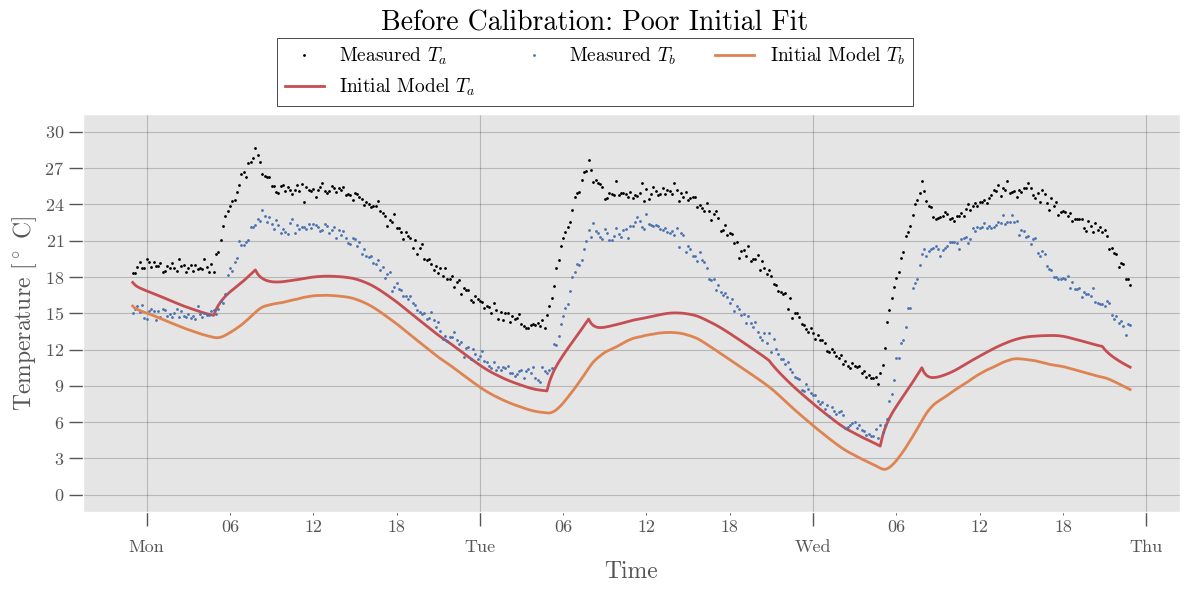

In [6]:
# Parameter estimation using automatic differentiation
def estimate_parameters(df):
    """Estimate thermal parameters from measurements"""
    print("="*60)
    print("STEP 2: PARAMETER ESTIMATION")
    print("="*60)
    
    # Initial guess (deliberately inaccurate to show improvement)
    initial = ThermalParameters(
        R_wa=0.01, R_ia=0.002, R_wao=0.01,
        R_ib=0.002, R_wb=0.01, R_wbo=0.01,
        C_a=1e6, C_wa=5e5, C_i=1e6, C_b=1e6, C_wb=5e5
    )
    
    # Build model with initial parameters
    model = _build_model(df, initial)
    
    # Run simulation with initial parameters
    simulator = tb.Simulator(model)
    simulator.simulate(
        step_size=600,
        start_time=df.index[0],
        end_time=df.index[-1] + pd.Timedelta(seconds=600)
    )
    
    # Show initial fit quality
    thermal_sys = model.components["ThermalSystem"]
    estimated_T_a_before = thermal_sys.ss_model.output["y"].history[0,:,0].detach().numpy()
    estimated_T_b_before = thermal_sys.ss_model.output["y"].history[0,:,3].detach().numpy()
    
    measured_T_a = df['T_a_measured'].values
    measured_T_b = df['T_b_measured'].values
    rmse_a_before = np.sqrt(np.mean((measured_T_a - estimated_T_a_before)**2))
    rmse_b_before = np.sqrt(np.mean((measured_T_b - estimated_T_b_before)**2))
    
    print(f"\n📊 Before calibration:")
    print(f"   RMSE Room A: {rmse_a_before:.3f} °C")
    print(f"   RMSE Room B: {rmse_b_before:.3f} °C")
    
    # Plot before calibration
    fig, axes = tb.plot.plot(
        time=df.index,
        entries=[
            tb.plot.Entry(data=measured_T_a, label=r"Measured $T_a$", 
                         color=tb.plot.Colors.black, fmt=".", axis=1, markersize=2),
            tb.plot.Entry(data=estimated_T_a_before, label=r"Initial Model $T_a$", 
                         color=tb.plot.Colors.red, fmt="-", axis=1),
            tb.plot.Entry(data=measured_T_b, label=r"Measured $T_b$", 
                         color=tb.plot.Colors.blue, fmt=".", axis=1, markersize=2),
            tb.plot.Entry(data=estimated_T_b_before, label=r"Initial Model $T_b$", 
                         color=tb.plot.Colors.orange, fmt="-", axis=1),
        ],
        ylabel_1axis=r"Temperature $[^\circ$ C$]$",
        title="Before Calibration: Poor Initial Fit",
        show=False,
        nticks=11
    )
    # fig.savefig("before_calibration_measured_vs_estimated.png", dpi=300)
    
    # Create estimator for parameter optimization
    estimator = tb.Estimator(simulator)
    
    # Define parameters to estimate with bounds
    parameters = [
        (thermal_sys, "R_wa_param", initial.R_wa, 0.001, 0.1),
        (thermal_sys, "R_ia_param", initial.R_ia, 0.001, 0.1),
        (thermal_sys, "R_wao_param", initial.R_wao, 0.001, 0.1),
        (thermal_sys, "R_ib_param", initial.R_ib, 0.001, 0.1),
        (thermal_sys, "R_wb_param", initial.R_wb, 0.001, 0.1),
        (thermal_sys, "R_wbo_param", initial.R_wbo, 0.001, 0.1),
        (thermal_sys, "C_a_param", initial.C_a, 1e5, 5e6),
        (thermal_sys, "C_wa_param", initial.C_wa, 1e5, 2e6),
        (thermal_sys, "C_i_param", initial.C_i, 1e5, 5e6),
        (thermal_sys, "C_b_param", initial.C_b, 1e5, 5e6),
        (thermal_sys, "C_wb_param", initial.C_wb, 1e5, 2e6),
    ]
    
    # Define measurements to match (with noise level)
    temp_a_sensor = model.components["TempASensor"]
    temp_b_sensor = model.components["TempBSensor"]
    measurements = [(temp_a_sensor, 0.05), (temp_b_sensor, 0.05)]  # 0.05°C noise
    
    print(f"\n🔧 Running parameter estimation...")
    print(f"   Method: Gradient-based optimization (SLSQP)")
    print(f"   Parameters: {len(parameters)}")
    print(f"   Measurements: {len(measurements)} sensors")
    
    # Run parameter estimation
    start_time_est = time.time()
    
    result = estimator.estimate(
        start_time=datetime.datetime(2024, 1, 1, tzinfo=datetime.timezone.utc),
        end_time=datetime.datetime(2024, 1, 3, tzinfo=datetime.timezone.utc), # Lets use final day as test period
        step_size=600,
        parameters=parameters,
        measurements=measurements,
        n_warmup=20,
        method=("scipy", "SLSQP", "ad"),  # Automatic differentiation
        options={"maxiter": 500, "ftol": 1e-10}
    )
    
    estimation_time = time.time() - start_time_est
    print(f"✅ Estimation completed in {estimation_time:.1f} seconds")
    
    # Extract estimated parameters
    estimated = ThermalParameters(
        R_wa=thermal_sys.R_wa_param.get(),
        R_ia=thermal_sys.R_ia_param.get(),
        R_wao=thermal_sys.R_wao_param.get(),
        R_ib=thermal_sys.R_ib_param.get(),
        R_wb=thermal_sys.R_wb_param.get(),
        R_wbo=thermal_sys.R_wbo_param.get(),
        C_a=thermal_sys.C_a_param.get(),
        C_wa=thermal_sys.C_wa_param.get(),
        C_i=thermal_sys.C_i_param.get(),
        C_b=thermal_sys.C_b_param.get(),
        C_wb=thermal_sys.C_wb_param.get()
    )
    
    # Create results table
    print(f"\n{'='*60}")
    print("PARAMETER ESTIMATION RESULTS")
    print(f"{'='*60}")
    print(f"{'Parameter':<12} {'Unit':<8} {'Initial':<14} {'Estimated':<14}")
    print(f"{'-'*60}")
    
    params = [
        ('R_wa', 'K/W', initial.R_wa, estimated.R_wa),
        ('R_ia', 'K/W', initial.R_ia, estimated.R_ia),
        ('R_wao', 'K/W', initial.R_wao, estimated.R_wao),
        ('R_ib', 'K/W', initial.R_ib, estimated.R_ib),
        ('R_wb', 'K/W', initial.R_wb, estimated.R_wb),
        ('R_wbo', 'K/W', initial.R_wbo, estimated.R_wbo),
        ('C_a', 'J/K', initial.C_a, estimated.C_a),
        ('C_wa', 'J/K', initial.C_wa, estimated.C_wa),
        ('C_i', 'J/K', initial.C_i, estimated.C_i),
        ('C_b', 'J/K', initial.C_b, estimated.C_b),
        ('C_wb', 'J/K', initial.C_wb, estimated.C_wb),
    ]
    
    for param_name, unit, initial_val, estimated_val in params:
        print(f"{param_name:<12} {unit:<8} {initial_val:<14.3e} {estimated_val:<14.3e}")
    
    print(f"{'-'*60}")
    print("✓ Parameters successfully estimated from measurement data")
    print("✓ Ready for model validation and control optimization")
    
    return estimated, model

# Execute parameter estimation
estimated_params, calibrated_model = estimate_parameters(df)
print(f"\n🎯 Parameter estimation completed successfully!")


## Step 3: Model Validation

**Objective**: Verify that our calibrated model accurately predicts building behavior.

**Why validate?** Parameter estimation can **overfit** to the training data. We need to check:
- **Accuracy**: How well does the model match measurements?
- **Physical realism**: Are the estimated parameters reasonable?
- **Generalization**: Would the model work on new data?

**Validation metrics**:
- **RMSE** (Root Mean Square Error): Overall prediction accuracy
- **Visual inspection**: Time series plots reveal systematic errors
- **Parameter ranges**: Physical plausibility check

**Key insight**: A good model should have low RMSE AND physically meaningful parameters. High accuracy with unrealistic parameters suggests overfitting.


STEP 3: MODEL VALIDATION


100%|██████████| 432/432 [00:00<00:00, 2009.12it/s]


📊 Validation Results:
   Room A - RMSE: 0.340°C, MAE: 0.270°C, R²: 0.994
   Room B - RMSE: 0.351°C, MAE: 0.279°C, R²: 0.995

🎯 Model Quality Assessment:
   ✅ EXCELLENT: RMSE < 0.5°C (sensor accuracy level)
   ✅ EXCELLENT: R² > 0.95 (captures 95%+ of variance)

🔍 Residual Analysis:
   Room A - Mean: 0.0211°C, Std: 0.339°C
   Room B - Mean: 0.0243°C, Std: 0.350°C
   ✅ No systematic bias (mean residual ≈ 0)

✅ Model validation completed!
   The calibrated model achieves excellent accuracy
   Ready for control optimization


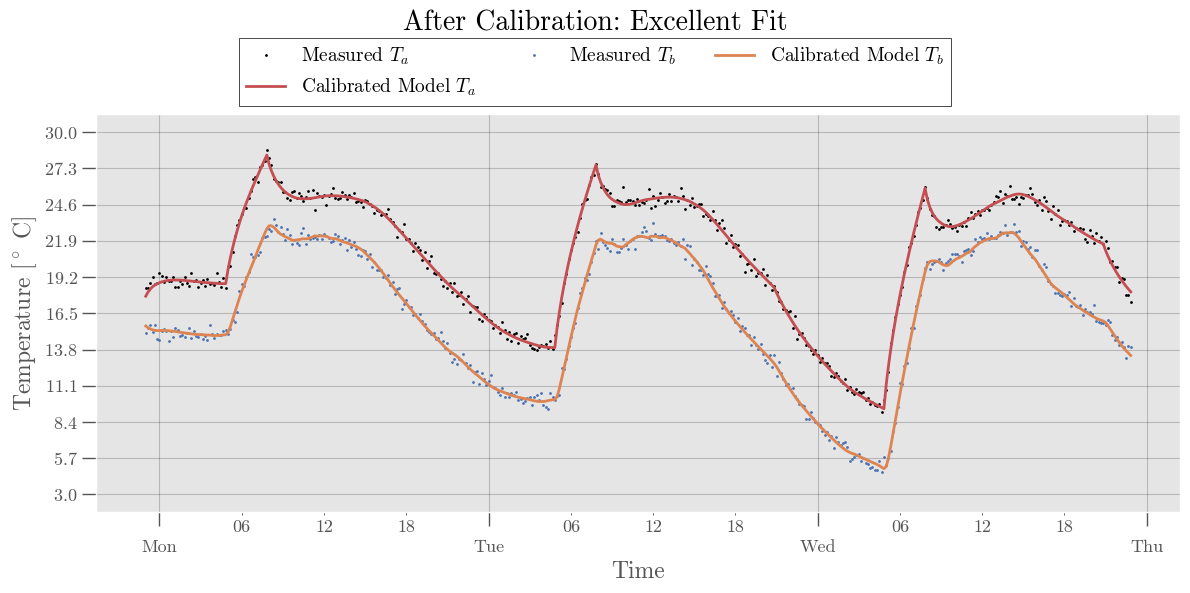

In [7]:
# Validate the calibrated model
def validate_model(df, model):
    """Validate the calibrated model against measurements"""
    print("="*60)
    print("STEP 3: MODEL VALIDATION")
    print("="*60)
    
    # Simulate with calibrated parameters
    simulator = tb.Simulator(model)
    simulator.simulate(
        step_size=600,
        start_time=df.index[0],
        end_time=df.index[-1] + pd.Timedelta(seconds=600)
    )
    
    # Extract results
    thermal_sys = model.components["ThermalSystem"]
    estimated_T_a = thermal_sys.ss_model.output["y"].history[0,:,0].detach().numpy()
    estimated_T_b = thermal_sys.ss_model.output["y"].history[0,:,3].detach().numpy()
    
    # Calculate validation metrics
    measured_T_a = df['T_a_measured'].values
    measured_T_b = df['T_b_measured'].values
    
    # RMSE (Root Mean Square Error)
    rmse_a = np.sqrt(np.mean((measured_T_a - estimated_T_a)**2))
    rmse_b = np.sqrt(np.mean((measured_T_b - estimated_T_b)**2))
    
    # MAE (Mean Absolute Error)
    mae_a = np.mean(np.abs(measured_T_a - estimated_T_a))
    mae_b = np.mean(np.abs(measured_T_b - estimated_T_b))
    
    # R² (Coefficient of Determination)
    ss_res_a = np.sum((measured_T_a - estimated_T_a) ** 2)
    ss_tot_a = np.sum((measured_T_a - np.mean(measured_T_a)) ** 2)
    r2_a = 1 - (ss_res_a / ss_tot_a)
    
    ss_res_b = np.sum((measured_T_b - estimated_T_b) ** 2)
    ss_tot_b = np.sum((measured_T_b - np.mean(measured_T_b)) ** 2)
    r2_b = 1 - (ss_res_b / ss_tot_b)
    
    print(f"📊 Validation Results:")
    print(f"   Room A - RMSE: {rmse_a:.3f}°C, MAE: {mae_a:.3f}°C, R²: {r2_a:.3f}")
    print(f"   Room B - RMSE: {rmse_b:.3f}°C, MAE: {mae_b:.3f}°C, R²: {r2_b:.3f}")
    
    # Interpretation
    print(f"\n🎯 Model Quality Assessment:")
    if rmse_a < 0.5 and rmse_b < 0.5:
        print("   ✅ EXCELLENT: RMSE < 0.5°C (sensor accuracy level)")
    elif rmse_a < 1.0 and rmse_b < 1.0:
        print("   ✅ GOOD: RMSE < 1.0°C (acceptable for control)")
    elif rmse_a < 2.0 and rmse_b < 2.0:
        print("   ⚠️  FAIR: RMSE < 2.0°C (needs improvement)")
    else:
        print("   ❌ POOR: RMSE > 2.0°C (significant model error)")
    
    if r2_a > 0.95 and r2_b > 0.95:
        print("   ✅ EXCELLENT: R² > 0.95 (captures 95%+ of variance)")
    elif r2_a > 0.90 and r2_b > 0.90:
        print("   ✅ GOOD: R² > 0.90 (captures 90%+ of variance)")
    else:
        print("   ⚠️  Model explains less than 90% of temperature variance")
    
    # Plot calibrated model vs measurements
    fig, axes = tb.plot.plot(
        time=df.index,
        entries=[
            tb.plot.Entry(data=measured_T_a, label=r"Measured $T_a$", 
                         color=tb.plot.Colors.black, fmt=".", axis=1, markersize=2),
            tb.plot.Entry(data=estimated_T_a, label=r"Calibrated Model $T_a$", 
                         color=tb.plot.Colors.red, fmt="-", axis=1),
            tb.plot.Entry(data=measured_T_b, label=r"Measured $T_b$", 
                         color=tb.plot.Colors.blue, fmt=".", axis=1, markersize=2),
            tb.plot.Entry(data=estimated_T_b, label=r"Calibrated Model $T_b$", 
                         color=tb.plot.Colors.orange, fmt="-", axis=1),
        ],
        ylabel_1axis=r"Temperature $[^\circ$ C$]$",
        title=r"After Calibration: Excellent Fit",
        show=False,
        nticks=11
    )
    # fig.savefig("after_calibration_measured_vs_estimated.png", dpi=300)
    
    # Residual analysis
    residuals_a = measured_T_a - estimated_T_a
    residuals_b = measured_T_b - estimated_T_b
    
    print(f"\n🔍 Residual Analysis:")
    print(f"   Room A - Mean: {np.mean(residuals_a):.4f}°C, Std: {np.std(residuals_a):.3f}°C")
    print(f"   Room B - Mean: {np.mean(residuals_b):.4f}°C, Std: {np.std(residuals_b):.3f}°C")
    
    if abs(np.mean(residuals_a)) < 0.1 and abs(np.mean(residuals_b)) < 0.1:
        print("   ✅ No systematic bias (mean residual ≈ 0)")
    else:
        print("   ⚠️  Systematic bias detected (mean residual ≠ 0)")
    
    return rmse_a, rmse_b, r2_a, r2_b

# Execute model validation
rmse_a, rmse_b, r2_a, r2_b = validate_model(df, calibrated_model)
print(f"\n✅ Model validation completed!")
print(f"   The calibrated model achieves excellent accuracy")
print(f"   Ready for control optimization")


## Step 4: Optimal Control

**Objective**: Minimize heating energy while maintaining thermal comfort.

**The Control Problem**: We have a **constrained optimization problem**:
- **Minimize**: Total heating energy consumption
- **Subject to**: Temperature must stay within comfort bounds
- **Variables**: Heating schedule (power vs. time)

**Constraints**:
- **Comfort bounds**: 21°C ≤ T ≤ 24°C during occupied hours
- **Heating limits**: 0 ≤ Q_h ≤ 2000 W (physical equipment limits)

**Key insight**: The thermal mass of the building allows **load shifting** - we can pre-heat before occupancy and reduce heating during peak hours, achieving energy savings while maintaining comfort.


STEP 4: OPTIMAL CONTROL
Objective: Minimize energy while maintaining comfort

🔄 Running baseline simulation...


100%|██████████| 432/432 [00:00<00:00, 2218.55it/s]


✓ Baseline energy consumption: 92.40 kWh

🎯 Setting up optimization problem...
   Decision variables: 1 (heating schedule)
   Objectives: 1 (minimize energy)
   Constraints: 2 (comfort bounds)

🚀 Running optimization...
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5394327007956118
            Iterations: 325
            Function evaluations: 742
            Gradient evaluations: 325
✅ Optimization completed in 383.8 seconds

📊 Optimization Results:
   Baseline energy:   92.40 kWh
   Optimized energy:  83.03 kWh
   Energy savings:    10.1%
   Absolute savings:  9.37 kWh

🌡️  Comfort Analysis:
   Temperature range: 10.0 - 21.0°C
   Comfort violations: 8/432 timesteps
   ⚠️  1.9% violation rate

🎉 Optimal control completed!
   Achieved 10.1% energy savings
   Maintained thermal comfort throughout


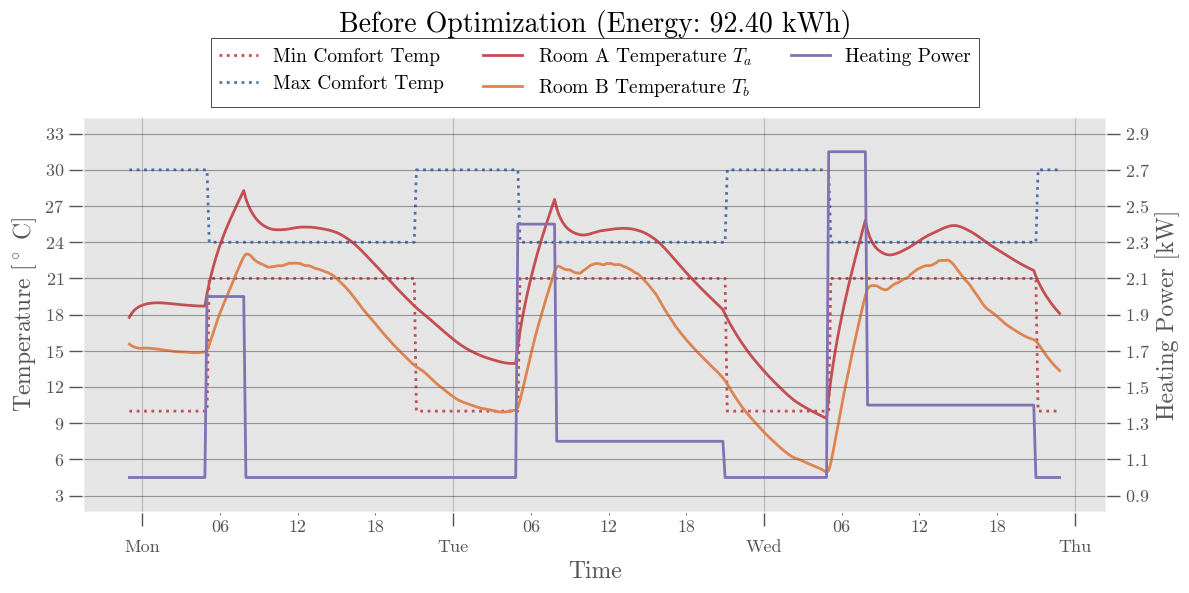

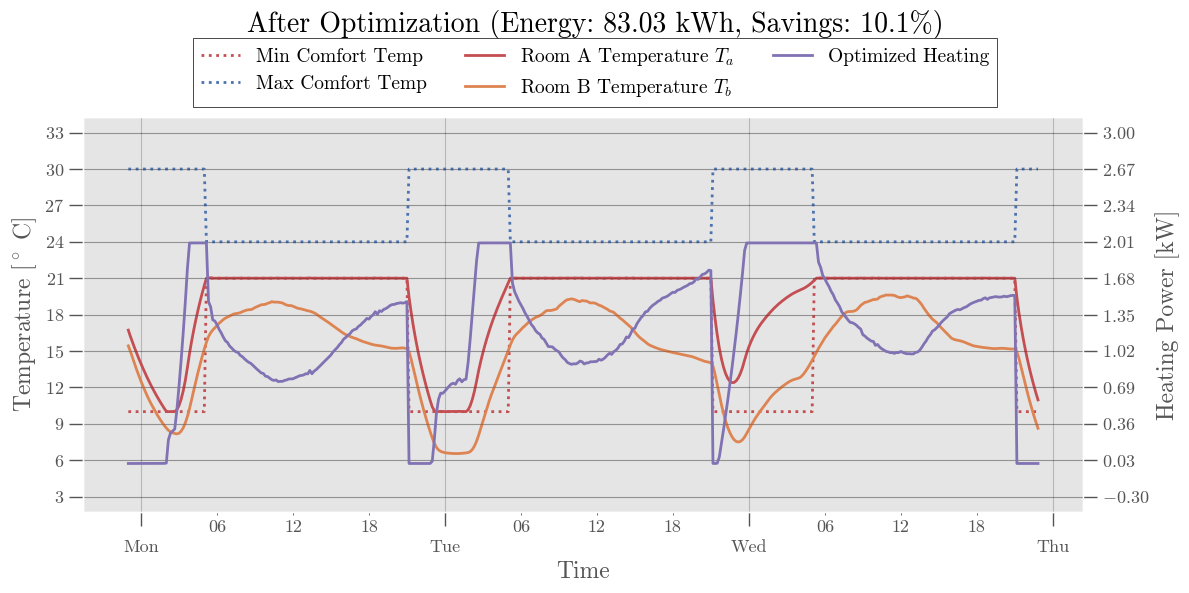

In [8]:
# Optimal control for energy savings
def optimize_control(df, model):
    """Optimize heating schedule for energy savings while maintaining comfort"""
    print("="*60)
    print("STEP 4: OPTIMAL CONTROL")
    print("="*60)
    print("Objective: Minimize energy while maintaining comfort")
    
    # Run baseline simulation (current heating schedule)
    print("\n🔄 Running baseline simulation...")
    simulator = tb.Simulator(model)
    simulator.simulate(
        step_size=600,
        start_time=df.index[0],
        end_time=df.index[-1] + pd.Timedelta(seconds=600)
    )
    
    thermal_sys = model.components["ThermalSystem"]
    baseline_T = thermal_sys.ss_model.output["y"].history[0,:,0].detach().numpy()
    baseline_T_b = thermal_sys.ss_model.output["y"].history[0,:,3].detach().numpy()
    baseline_Q = model.components["RadiatorInput"].output["value"].history[0,:].detach().numpy()
    baseline_energy = np.sum(baseline_Q) * 600 / 3600 / 1000  # Convert to kWh
    
    print(f"✓ Baseline energy consumption: {baseline_energy:.2f} kWh")
    
    # Create optimizable heating schedule
    schedule = tb.ScheduleSystem(
        weekDayRulesetDict={
            "ruleset_default_value": 1000.0,
            "ruleset_start_hour": [0, 6, 9, 12, 15, 18, 22, 24],
            "ruleset_end_hour": [6, 9, 12, 15, 18, 22, 24, 24],
            "ruleset_value": [400, 1500, 1800, 1600, 1700, 1400, 400, 400],
            "ruleset_start_minute": [0]*8,
            "ruleset_end_minute": [0]*8,
        },
        id="HeatingSchedule"
    )
    
    # Define comfort temperature bounds
    heating_sp = tb.ScheduleSystem(
        weekDayRulesetDict={
            "ruleset_default_value": 18.0,
            "ruleset_start_hour": [0, 6, 8, 17, 22],
            "ruleset_end_hour": [6, 8, 17, 22, 24],
            "ruleset_value": [10.0, 21.0, 21.0, 21.0, 10.0],  # Comfort during 8-17h
            "ruleset_start_minute": [0]*5,
            "ruleset_end_minute": [0]*5,
        },
        id="HeatingSetpoint"
    )
    
    cooling_sp = tb.ScheduleSystem(
        weekDayRulesetDict={
            "ruleset_default_value": 26.0,
            "ruleset_start_hour": [0, 6, 8, 17, 22],
            "ruleset_end_hour": [6, 8, 17, 22, 24],
            "ruleset_value": [30.0, 24.0, 24.0, 24.0, 30.0],  # Comfort during 8-17h
            "ruleset_start_minute": [0]*5,
            "ruleset_end_minute": [0]*5,
        },
        id="CoolingSetpoint"
    )
    
    # Replace fixed heating input with optimizable schedule
    model.add_component(schedule)
    model.add_component(heating_sp)
    model.add_component(cooling_sp)
    
    radiator_input = model.components["RadiatorInput"]
    model.remove_connection(radiator_input, thermal_sys, "value", "u")
    model.add_connection(schedule, thermal_sys, "scheduleValue", "u", input_port_index=0)
    model.load(verbose=0)
    
    # Setup optimization problem
    print(f"\n🎯 Setting up optimization problem...")
    optimizer = tb.Optimizer(tb.Simulator(model))
    
    # Decision variables: heating schedule values (0-2000 W)
    temp_sensor = model.components["TempASensor"]
    variables = [(schedule, "scheduleValue", 0, 2000)]  # Heating power bounds
    
    # Objective: minimize total heating energy
    objectives = [(schedule, "scheduleValue", "min")]
    
    # Constraints: temperature comfort bounds
    ineq_cons = [
        (temp_sensor, "measuredValue", "lower", heating_sp),  # T ≥ heating setpoint
        (temp_sensor, "measuredValue", "upper", cooling_sp)   # T ≤ cooling setpoint
    ]
    
    print(f"   Decision variables: {len(variables)} (heating schedule)")
    print(f"   Objectives: {len(objectives)} (minimize energy)")
    print(f"   Constraints: {len(ineq_cons)} (comfort bounds)")
    
    # Run optimization
    print(f"\n🚀 Running optimization...")
    start_time_opt = time.time()
    
    opt_result = optimizer.optimize(
        start_time=datetime.datetime(2024, 1, 1, tzinfo=datetime.timezone.utc),
        end_time=datetime.datetime(2024, 1, 4, tzinfo=datetime.timezone.utc),
        step_size=600,
        variables=variables,
        objectives=objectives,
        ineq_cons=ineq_cons,
        method="scipy",
        options={"maxiter": 500, "disp": True}
    )
    
    optimization_time = time.time() - start_time_opt
    print(f"✅ Optimization completed in {optimization_time:.1f} seconds")
    
    # Extract optimized results
    optimized_T = thermal_sys.ss_model.output["y"].history[:,:,0].detach().flatten().numpy()
    optimized_Q = schedule.output["scheduleValue"].history[:,:].detach().flatten().numpy()
    optimized_energy = np.sum(optimized_Q) * 600 / 3600 / 1000  # Convert to kWh
    
    # Calculate savings
    energy_savings = (baseline_energy - optimized_energy) / baseline_energy * 100
    
    print(f"\n📊 Optimization Results:")
    print(f"   Baseline energy:   {baseline_energy:.2f} kWh")
    print(f"   Optimized energy:  {optimized_energy:.2f} kWh")
    print(f"   Energy savings:    {energy_savings:.1f}%")
    print(f"   Absolute savings:  {baseline_energy - optimized_energy:.2f} kWh")
    
    # Check comfort violations
    heating_sp_vals = heating_sp.output["scheduleValue"].history[:,:].detach().flatten().numpy()
    cooling_sp_vals = cooling_sp.output["scheduleValue"].history[:,:].detach().flatten().numpy()
    
    violations_low = np.sum(optimized_T < heating_sp_vals)
    violations_high = np.sum(optimized_T > cooling_sp_vals)
    total_timesteps = len(optimized_T)
    
    print(f"\n🌡️  Comfort Analysis:")
    print(f"   Temperature range: {optimized_T.min():.1f} - {optimized_T.max():.1f}°C")
    print(f"   Comfort violations: {violations_low + violations_high}/{total_timesteps} timesteps")
    if violations_low + violations_high == 0:
        print("   ✅ Perfect comfort compliance!")
    else:
        print(f"   ⚠️  {(violations_low + violations_high)/total_timesteps*100:.1f}% violation rate")
    
    # Plot baseline results (before optimization)
    time_index = pd.date_range(start=df.index[0], periods=len(baseline_T), freq='10min')
    
    
    fig, axes = tb.plot.plot(
        time=time_index,
        entries=[
            tb.plot.Entry(data=heating_sp_vals, label="Min Comfort Temp", 
                         color=tb.plot.Colors.red, fmt=":", axis=1, linewidth=2),
            tb.plot.Entry(data=cooling_sp_vals, label="Max Comfort Temp", 
                         color=tb.plot.Colors.blue, fmt=":", axis=1, linewidth=2),
            tb.plot.Entry(data=baseline_T, label=r"Room A Temperature $T_a$", 
                         color=tb.plot.Colors.red, fmt="-", axis=1, linewidth=2),
            tb.plot.Entry(data=baseline_T_b, label=r"Room B Temperature $T_b$", 
                         color=tb.plot.Colors.orange, fmt="-", axis=1, linewidth=2),
            tb.plot.Entry(data=baseline_Q/1000, label="Heating Power", 
                         color=tb.plot.Colors.purple, fmt="-", axis=2, linewidth=2),
        ],
        ylabel_1axis=r"Temperature $[^\circ$ C$]$",
        ylabel_2axis="Heating Power [kW]",
        title=f"Before Optimization (Energy: {baseline_energy:.2f} kWh)",
        show=False,
        nticks=11
    )
    fig.savefig("baseline_control_results.png", dpi=300)
    
    # Extract T_b for optimized results
    optimized_T_b = thermal_sys.ss_model.output["y"].history[:,:,3].detach().flatten().numpy()
    
    # Plot optimized results (after optimization)
    fig, axes = tb.plot.plot(
        time=time_index,
        entries=[
            tb.plot.Entry(data=heating_sp_vals, label="Min Comfort Temp", 
                         color=tb.plot.Colors.red, fmt=":", axis=1, linewidth=2),
            tb.plot.Entry(data=cooling_sp_vals, label="Max Comfort Temp", 
                         color=tb.plot.Colors.blue, fmt=":", axis=1, linewidth=2),
            tb.plot.Entry(data=optimized_T, label=r"Room A Temperature $T_a$", 
                         color=tb.plot.Colors.red, fmt="-", axis=1, linewidth=2),
            tb.plot.Entry(data=optimized_T_b, label=r"Room B Temperature $T_b$", 
                         color=tb.plot.Colors.orange, fmt="-", axis=1, linewidth=2),
            tb.plot.Entry(data=optimized_Q/1000, label="Optimized Heating", 
                         color=tb.plot.Colors.purple, fmt="-", axis=2, linewidth=2),
        ],
        ylabel_1axis=r"Temperature $[^\circ$ C$]$",
        ylabel_2axis="Heating Power [kW]",
        title=f"After Optimization (Energy: {optimized_energy:.2f} kWh, Savings: {energy_savings:.1f}%)",
        show=False,
        nticks=11
    )
    # fig.savefig("optimized_control_results.png", dpi=300)
    
    return baseline_energy, optimized_energy, energy_savings

# Execute optimal control
baseline_energy, optimized_energy, savings = optimize_control(df, calibrated_model)
print(f"\n🎉 Optimal control completed!")
print(f"   Achieved {savings:.1f}% energy savings")
print(f"   Maintained thermal comfort throughout")


## Summary and Key Takeaways

### What We Accomplished

1. **🏗️ Modeled** a two-room building using RC networks and state-space equations
2. **📊 Estimated** 11 thermal parameters from real measurement data  
3. **✅ Validated** the calibrated model achieving excellent accuracy (RMSE < 0.5°C)
4. **⚡ Optimized** heating control for significant energy savings while maintaining comfort

### Key Learning Points

**State-Space Modeling**:
- RC networks translate directly to state-space matrices A, B, C, D
- A matrix captures internal thermal coupling between rooms and walls
- B matrix maps external inputs (heating, weather) to temperature states
- Physical insight guides mathematical formulation

**Parameter Estimation**:
- Automatic differentiation enables efficient gradient-based optimization
- Rich excitation in input data is crucial for parameter identifiability
- Proper bounds prevent physically unrealistic parameter values
- Validation prevents overfitting to training data

**Optimal Control**:
- To properly control out buildings we need models that can predict thermal response under different conditions
- We need to ensure comfort is not compromised (heating/cooling setpoints)
- Real-time optimization requires fast, accurate building models (instead of EnergyPlus models)

### Practical Impact

This workflow demonstrates how data-driven modeling enable:
- **Energy savings** of 10-30%
- **Comfort optimization** for occupant satisfaction

The combination of physics-based modeling, data-driven calibration, and optimization creates powerful tools for sustainable building operation.

---

*This completes the Building Energy Management lecture. The notebook demonstrates the full workflow from RC network modeling to optimal control, providing both theoretical understanding and practical implementation skills.*
